In [1]:
import matplotlib.pyplot as plt
import mpmath
from numba import jit
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d,interp2d,RegularGridInterpolator
from scipy import stats
import time

In [2]:
sr2 = np.sqrt(2)
sr2π = np.sqrt(2*np.pi)

# Rate Moment Calculator

In [3]:
class RateCalc:
    def Φ(self, μ: float) -> float:
        pass
    
    def M(self, μ: float, σ: float) -> float:
        pass
    
    def C(self, μ: float, σ: float, ρ: float) -> float:
        pass

In [4]:
def μtox(μ: float) -> float:
    return np.sign(μ/100-0.2)*np.abs(μ/100-0.2)**0.5

def xtoμ(x: float) -> float:
    return 100*(np.sign(x)*np.abs(x)**2.0+0.2)

In [5]:
class RicciardiCalc(RateCalc):
    def __init__(self, θ: float, Vr: float, σn: float, τs: float, τr: float):
        self.θ = θ
        self.Vr = Vr
        self.σn = σn
        self.τs = τs
        self.τr = τr
        
    def Φint(self, μ: float) -> float:
        umax = (self.θ-μ)/self.σn
        umin = (self.Vr-μ)/self.σn
        if umin > 10:
            return umax*np.exp(-umax**2)/self.τs
        elif umin > -4:
            return 1/(self.τr+self.τs*(0.5*np.pi*\
                                       (mpmath.fp.erfi(umax)-mpmath.fp.erfi(umin)) +
                    umax**2*mpmath.fp.hyp2f2(1.0,1.0,1.5,2.0,umax**2) -
                    umin**2*mpmath.fp.hyp2f2(1.0,1.0,1.5,2.0,umin**2)))
        else:
            return 1/(self.τr+self.τs*(np.log(abs(umin))-np.log(abs(umax)) +
                    (0.25*umin**-2-0.1875*umin**-4+0.3125*umin**-6-
                        0.8203125*umin**-8+2.953125*umin**-10) -
                    (0.25*umax**-2-0.1875*umax**-4+0.3125*umax**-6-
                        0.8203125*umax**-8+2.953125*umax**-10)))
        
    def Φitp(self):
        xs = np.linspace(μtox(-1E3), μtox(1E5), 10**5+1)
        μs = xtoμ(xs)
        μs[0] = -1E8
        μs[-1] = 1E8
        Φs = np.zeros(len(μs))
        for i, μ in enumerate(μs):
            Φs[i] = self.Φint(μ)
        self.Φitps = interp1d(μs, Φs, 'cubic')
        
    def Φ(self, μ: float) -> float:
        return self.Φitps(np.asarray(μ))
        
    def Mint(self, μ: float, σ: float) -> float:
        if np.isclose(σ,0.0):
            return self.Φ(μ)
        return integrate.quad(lambda x: np.exp(-0.5*x**2)/sr2π*self.Φ(μ+σ*x),-6,6)[0]
    
    def Mitp(self):
        xs = np.linspace(μtox(-800.0), μtox(1000.0), 200+1)
        μs = xtoμ(xs)
        μs[0] = -1E7
        μs[-1] = 1E7
        σs = np.linspace(0.0, 60.0, 240+1)
        Ms = np.zeros((len(σs),len(μs)))
        for i, μ in enumerate(μs):
            for j, σ in enumerate(σs):
                Ms[j,i] = self.Mint(μ,σ)
        self.Mitps = interp2d(μs, σs, Ms, 'cubic')
        
    def M(self, μ: float, σ: float) -> float:
        return self.Mitps(np.asarray(μ),np.asarray(σ))
    
#     def Cint(self, μ1: float, μ2: float, σ1: float, σ2: float, ρ: float) -> float:
#         if np.isclose(ρ, 0.0):
#             return self.M(μ1,σ1)*self.M(μ2,σ2)
#         c = 0.0
#         if not np.isclose(σ1, 0.0) and not np.isclose(σ2, 0.0):
#             c = np.sign(ρ)*min(np.abs(ρ)/(σ1*σ2),1)
#         return integrate.quad(lambda x: np.exp(-0.5*x**2)/sr2π*\
#             self.M(μ1+np.sign(c)*σ1*np.sqrt(np.abs(c))*x,σ1*np.sqrt(1-np.abs(c)))*\
#             self.M(μ2+σ2*np.sqrt(np.abs(c))*x,σ2*np.sqrt(1-np.abs(c))),-6,6)[0]
    
    def Cint(self, μ: float, σ: float, ρ: float) -> float:
        if np.isclose(ρ, 0.0):
            return self.M(μ,σ)**2
        c = 0.0
        if not np.isclose(σ, 0.0):
            c = np.sign(ρ)*min(np.abs(ρ)/σ**2,1)
        return integrate.quad(lambda x: np.exp(-0.5*x**2)/sr2π*\
            self.M(μ+np.sign(c)*σ*np.sqrt(np.abs(c))*x,σ*np.sqrt(1-np.abs(c)))*\
            self.M(μ+σ*np.sqrt(np.abs(c))*x,σ*np.sqrt(1-np.abs(c))),-6,6)[0]
    
    def Citp(self):
        xs = np.linspace(μtox(-400.0), μtox(200.0), 100+1)
        μs = xtoμ(xs)
        μs[0] = -1E6
        μs[-1] = 1E6
        σs = np.linspace(0.0, 60.0, 120+1)
        cs = np.linspace(-0.1, 1.0, 11+1)
        Cs = np.zeros((len(μs),len(σs),len(cs)))
        for i, μ in enumerate(μs):
            for j, σ in enumerate(σs):
                for k, c in enumerate(cs):
                    Cs[i,j,k] = self.Cint(μ,σ,σ**2*c)
        self.Citps = RegularGridInterpolator([μs,σs,cs], Cs)
    
    def C(self, μ: float, σ: float, ρ: float) -> float:
        c = np.zeros_like(ρ)
        mask = np.invert(np.isclose(np.asarray(σ),0.0))
        c[mask] = np.sign(np.asarray(ρ)[mask])*np.minimum(np.abs(np.asarray(ρ)[mask])/\
                                                   np.asarray(σ)[mask]**2,1)
        return self.Citps(np.stack((μ,σ,c)).T)

In [6]:
rcE = RicciardiCalc(20.0,10.0,10.0,0.02,0.002)
rcI = RicciardiCalc(20.0,10.0,10.0,0.01,0.002)

In [7]:
start = time.process_time()
rcE.Φitp()
rcI.Φitp()
print(time.process_time()-start)
del start

2.9262479999999997


In [8]:
start = time.process_time()
rcE.Mitp()
rcI.Mitp()
print(time.process_time()-start)
del start

861.6788479999999


In [9]:
start = time.process_time()
rcE.Citp()
rcI.Citp()
print(time.process_time()-start)
del start

2382.723553


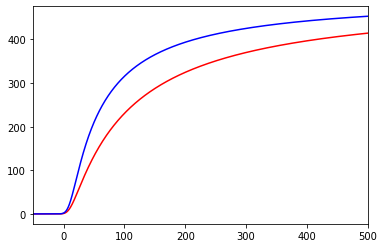

In [10]:
μs = np.linspace(-50,500,1000)
plt.plot(μs,rcE.Φ(μs),'r')
plt.plot(μs,rcI.Φ(μs),'b')
plt.xlim((μs[0],μs[-1]))
plt.show()
del μs

# Opto-Stimulated Rate Moment Calculator

In [11]:
class OptoRateCalc:
    def ΦL(self, μ: float) -> float:
        pass
    
    def ML(self, μ: float, σ: float) -> float:
        pass
    
    def CL(self, μ: float, σ: float, ρ: float) -> float:
        pass
    
    def RL(self, μ1: float, μ2: float, σ1: float, σ2: float, ρ: float) -> float:
        pass

In [12]:
class LogNormalOptoRateCalc(OptoRateCalc):
    def __init__(self, rc, s: float, λL: float):
        self.rc = rc
        self.s = s
        self.λL = λL
        σ2 = np.log(1+s**2)
        self.σ = np.sqrt(σ2)
        self.μ = np.log(λL)-0.5*σ2
        
    def ΦLint(self, μ: float) -> float:
        return integrate.quad(lambda x: np.exp(-0.5*((np.log(x)-self.μ)/self.σ)**2)/\
                              (sr2π*self.σ*x)*self.rc.Φ(μ+x),0,50*self.λL)[0]
    
    def ΦLitp(self):
        xs = np.linspace(μtox(-1E3), μtox(1E5), 2*10**4+1)
        μs = xtoμ(xs)
        μs[0] = -1E8
        μs[-1] = 2E7
        ΦLs = np.zeros(len(μs))
        for i, μ in enumerate(μs):
            ΦLs[i] = self.ΦLint(μ)
        self.ΦLitps = interp1d(μs, ΦLs, 'cubic')
        
    def ΦL(self, μ: float) -> float:
        return self.ΦLitps(np.asarray(μ))
        
    def MLint(self, μ: float, σ: float) -> float:
        if np.isclose(σ,0.0):
            return self.ΦL(μ)
        return integrate.quad(lambda x: np.exp(-0.5*((np.log(x)-self.μ)/self.σ)**2)/\
                              (sr2π*self.σ*x)*self.rc.M(μ+x,σ),0,50*self.λL)[0]
    
    def MLitp(self):
        xs = np.linspace(μtox(-800.0), μtox(500.0), 150+1)
        μs = xtoμ(xs)
        μs[0] = -1E7
        μs[-1] = 2E6
        σs = np.linspace(0.0, 60.0, 240+1)
        MLs = np.zeros((len(σs),len(μs)))
        for i, μ in enumerate(μs):
            for j, σ in enumerate(σs):
                MLs[j,i] = self.MLint(μ,σ)
        self.MLitps = interp2d(μs, σs, MLs, 'cubic')
        
    def ML(self, μ: float, σ: float) -> float:
        return self.MLitps(np.asarray(μ),np.asarray(σ))
    
#     def CLint(self, μ1: float, μ2: float, σ1: float, σ2: float, ρ: float) -> float:
#         if np.isclose(ρ, 0.0):
#             return integrate.quad(lambda x: np.exp(-0.5*((np.log(x)-self.μ)/self.σ)**2)/\
#                                   (sr2π*self.σ*x)*self.rc.M(μ1+x,σ1)*self.rc.M(μ2+x,σ2),
#                                   0,50*self.λL)[0]
#         return integrate.quad(lambda x: np.exp(-0.5*((np.log(x)-self.μ)/self.σ)**2)/\
#                               (sr2π*self.σ*x)*self.rc.C(μ1+x,μ2+x,σ1,σ2,ρ),
#                               0,50*self.λL)[0]
    
    def CLint(self, μ: float, σ: float, ρ: float) -> float:
        if np.isclose(ρ, 0.0):
            return integrate.quad(lambda x: np.exp(-0.5*((np.log(x)-self.μ)/self.σ)**2)/\
                                  (sr2π*self.σ*x)*self.rc.M(μ+x,σ)**2,0,50*self.λL)[0]
        return integrate.quad(lambda x: np.exp(-0.5*((np.log(x)-self.μ)/self.σ)**2)/\
                              (sr2π*self.σ*x)*self.rc.C(μ+x,σ,ρ),0,50*self.λL)[0]
    
    def CLitp(self):
        xs = np.linspace(μtox(-400.0), μtox(100.0), 80+1)
        μs = xtoμ(xs)
        μs[0] = -1E6
        μs[-1] = 1E5
        σs = np.linspace(0.0, 60.0, 120+1)
        cs = np.linspace(0.0, 1.0, 10+1)
        CLs = np.zeros((len(μs),len(σs),len(cs)))
        for i, μ in enumerate(μs):
            for j, σ in enumerate(σs):
                for k, c in enumerate(cs):
                    CLs[i,j,k] = self.CLint(μ,σ,σ**2*c)
        self.CLitps = RegularGridInterpolator([μs,σs,cs], CLs)
    
    def CL(self, μ: float, σ: float, ρ: float) -> float:
        c = np.zeros_like(ρ)
        mask = np.invert(np.isclose(np.asarray(σ),0.0))
        c[mask] = np.sign(np.asarray(ρ)[mask])*np.minimum(np.abs(np.asarray(ρ)[mask])/\
                                                   np.asarray(σ)[mask]**2,1)
        return self.CLitps(np.stack((μ,σ,c)).T)
    
    def RLint(self, μ1: float, μ2: float, σ1: float, σ2: float, ρ: float) -> float:
        if np.isclose(ρ, 0.0):
            return self.rc.M(μ1,σ1)*self.ML(μ2,σ2)
        c = 0.0
        if not np.isclose(σ1, 0.0) and not np.isclose(σ2, 0.0):
            c = np.sign(ρ)*min(np.abs(ρ)/(σ1*σ2),1)
        return integrate.quad(lambda x: np.exp(-0.5*x**2)/sr2π*\
            self.rc.M(μ1+np.sign(c)*σ1*np.sqrt(np.abs(c))*x,σ1*np.sqrt(1-np.abs(c)))*\
            self.ML(μ2+σ2*np.sqrt(np.abs(c))*x,σ2*np.sqrt(1-np.abs(c))),-6,6)[0]
    
    def RL(self, μ1: float, μ2: float, σ1: float, σ2: float, ρ: float) -> float:
        return self.RLint(μ1,μ2,σ1,σ2,ρ)

In [13]:
orcE = LogNormalOptoRateCalc(rcE,10.0**0.58,10.0**1.02)

In [14]:
start = time.process_time()
orcE.ΦLitp()
print(time.process_time()-start)
del start

1735.7755279999997


In [15]:
start = time.process_time()
orcE.MLitp()
print(time.process_time()-start)
del start

821.4521239999995


In [16]:
start = time.process_time()
orcE.CLitp()
print(time.process_time()-start)
del start

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_6874/3875260711.py:61: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: np.exp(-0.5*((np.log(x)-self.μ)/self.σ)**2)/\

KeyboardInterrupt



In [ ]:
μs = np.linspace(-50,500,1000)
plt.plot(μs,orcE.ΦL(μs),'r')
plt.plot(μs,rcI.Φ(μs),'b')
plt.xlim((μs[0],μs[-1]))
plt.show()
del μs